# Phase 1: Comparing YOLO Models Using Weights & Biases (W&B)





### ⚙️ Install dependencies


In [1]:
!pip install wandb
!wandb login
!pip install roboflow ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/12

### Import data

In [3]:
from roboflow import Roboflow
from getpass import getpass

# Prompt for the key securely
api_key = getpass("Enter your Roboflow API key:")
rf = Roboflow(api_key=api_key)

project = rf.workspace("xray-chest-nodule").project("xray-chest-nodule")
dataset = project.version(7).download("yolov8")

Enter your Roboflow API key:··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to XRay-Chest-Nodule-7 in yolov8:: 100%|██████████| 10029/10029 [00:03<00:00, 3199.72it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!find /content -name "data.yaml"

In [ ]:
#  move 10% of train images + labels to valid
!mkdir -p /content/XRay-Chest-Nodule-7/valid/images
!mkdir -p /content/XRay-Chest-Nodule-7/valid/labels

In [4]:
import os, random, shutil

src_img = '/content/XRay-Chest-Nodule-7/train/images'
src_lbl = '/content/XRay-Chest-Nodule-7/train/labels'
dst_img = '/content/XRay-Chest-Nodule-7/valid/images'
dst_lbl = '/content/XRay-Chest-Nodule-7/valid/labels'

os.makedirs(dst_img, exist_ok=True)
os.makedirs(dst_lbl, exist_ok=True)

images = os.listdir(src_img)
random.shuffle(images)

val_split = 0.1
val_count = int(len(images) * val_split)

for img_name in images[:val_count]:
    lbl_name = img_name.replace('.jpg', '.txt').replace('.png', '.txt')
    shutil.move(os.path.join(src_img, img_name), os.path.join(dst_img, img_name))
    shutil.move(os.path.join(src_lbl, lbl_name), os.path.join(dst_lbl, lbl_name))

### Mount Drive & Prepare Save Path

In [5]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Define where to save weights
CHECKPOINT_DIR = "/content/drive/MyDrive/yolo_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


Mounted at /content/drive


## 📌 Phase 2 & 3: Fine-Tuning YOLOv8x (Frozen vs. Unfrozen Backbone)

To evaluate YOLOv8x on chest X-ray images, we fine-tuned the model using two strategies:

- **Phase 1**: Backbone frozen — only the detection heads were updated.
- **Phase 2**: Full model fine-tuning — all layers (including the backbone) were trained.

Both phases used:
- `loss_ota=True` → for improved target matching
- `cos_lr=True` → for smoother and more stable learning rate scheduling

To keep the notebook short, we only include the training code for the frozen backbone phase.  
✅ However, **both versions were trained**, and the results will be compared using WandB below.


In [ ]:
import os
import time
import wandb
from ultralytics import YOLO

# Constants
DATA_YAML = "/kaggle/working/XRay-Chest-Nodule-7/data.yaml"
EPOCHS = 100
IMGSZ = 640
BATCH = 4

# SOTA training configs
HYPERPARAMS = {
    "lr0": 1e-3,              # Initial LR
    "lrf": 0.1,               # Final LR fraction
    "momentum": 0.937,
    "weight_decay": 0.0005,   # Weight decay (AdamW)
    "warmup_epochs": 3,
    "warmup_momentum": 0.8,
    "warmup_bias_lr": 0.1,
    "box": 0.05,
    "cls": 0.5,
    "cls_pw": 1.0,
    "obj": 1.0,
    "obj_pw": 1.0,
    "iou_t": 0.2,
    "anchor_t": 4.0,
    "fl_gamma": 0.0,
    "hsv_h": 0.015,
    "hsv_s": 0.7,
    "hsv_v": 0.4,
    "degrees": 0.0,
    "translate": 0.1,
    "scale": 0.5,
    "shear": 0.0,
    "perspective": 0.0,
    "flipud": 0.0,
    "fliplr": 0.5,
    "mosaic": 1.0,
    "mixup": 0.2,
    "copy_paste": 0.0,
    "optimizer": "AdamW"
}

# List of models to fine-tune
models = [
    "yolov8x.pt",
]

for model_name in models:
    run_name = f"run_{model_name.replace('.pt', '')}_all_layers"
    wandb.init(project="Fine_tuning_yolov8x", name=run_name)
    wandb.config.update(HYPERPARAMS)

    # Load model
    model = YOLO(model_name)

    # Train
    model.train(
        data=DATA_YAML,
        epochs=EPOCHS,
        imgsz=IMGSZ,
        batch=BATCH,
        project=CHECKPOINT_DIR,
        name=run_name,
        exist_ok=True,
        # resume=True,
        save_period=-1,
        verbose=False,
        amp=True,                     # ⚡️ Mixed precision
        patience=5,                  # ⏳ Early stopping patience
        lr0=HYPERPARAMS["lr0"],
        lrf=HYPERPARAMS["lrf"],
        optimizer=HYPERPARAMS["optimizer"],
        warmup_epochs=HYPERPARAMS["warmup_epochs"],
        momentum=HYPERPARAMS["momentum"],
        weight_decay=HYPERPARAMS["weight_decay"],
        degrees=HYPERPARAMS["degrees"],
        translate=HYPERPARAMS["translate"],
        scale=HYPERPARAMS["scale"],
        shear=HYPERPARAMS["shear"],
        perspective=HYPERPARAMS["perspective"],
        flipud=HYPERPARAMS["flipud"],
        fliplr=HYPERPARAMS["fliplr"],
        mosaic=HYPERPARAMS["mosaic"],
        mixup=HYPERPARAMS["mixup"],
        val=True,
        # freeze = 10,
        device = 0,
    )

    import pandas as pd

    results_csv = os.path.join(CHECKPOINT_DIR, run_name, "results.csv")
    if os.path.exists(results_csv):
      df = pd.read_csv(results_csv)
      for epoch, row in df.iterrows():
          wandb.log({
              "epoch": int(row["epoch"]),
              "mAP50": row["metrics/mAP50(B)"],
              "mAP50-95": row["metrics/mAP50-95(B)"],
              "Precision": row["metrics/precision(B)"],
              "Recall": row["metrics/recall(B)"],
              "train/box_loss": row["train/box_loss"],
              "val/box_loss": row["val/box_loss"],
          })


    wandb.finish()


Precision,▁▂▃▅▃▅▅▅▅▇▄▆▆▂▇▇▅▇▆▆▇▆▇█▇▇▇█▇▇▇▇█▇▇█▇█▇
Recall,▁▃▂▄▅▅▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇█▇▇▇▇███▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
mAP50,▁▃▂▅▅▅▆▆▆▇▇▆▆▇▇▇█▇▇▇█▇▇███▇█▇▇▇████▇███
mAP50-95,▁▂▂▄▄▄▄▄▅▅▅▅▅▅▆▅▆▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇█▇▇▇▇██
train/box_loss,█▇▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val/box_loss,███▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▄▄▄▄▃▄▃▃▂▃▂▃▂▁▂▂▂▁▁▁
Precision,0.95786
Recall,0.90984
epoch,39
mAP50,0.95538


## 📌 Phase 4: Visualizing YOLOv8x Results — Metrics and Evaluation Graphs

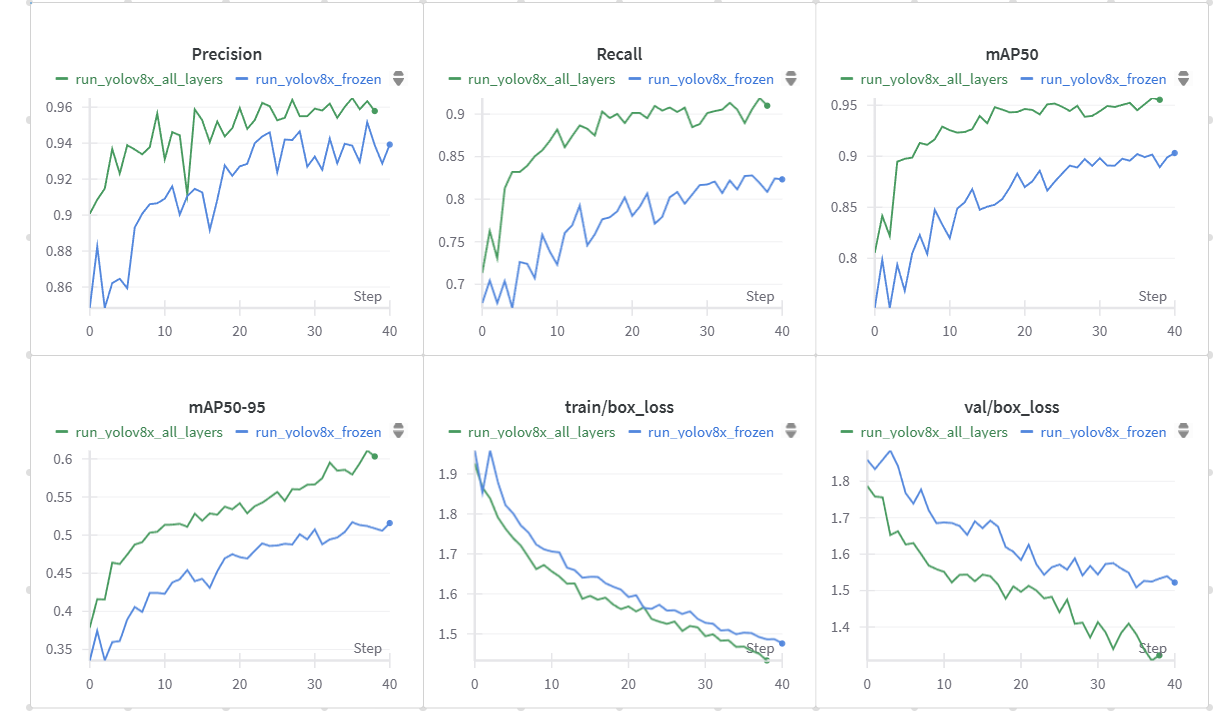

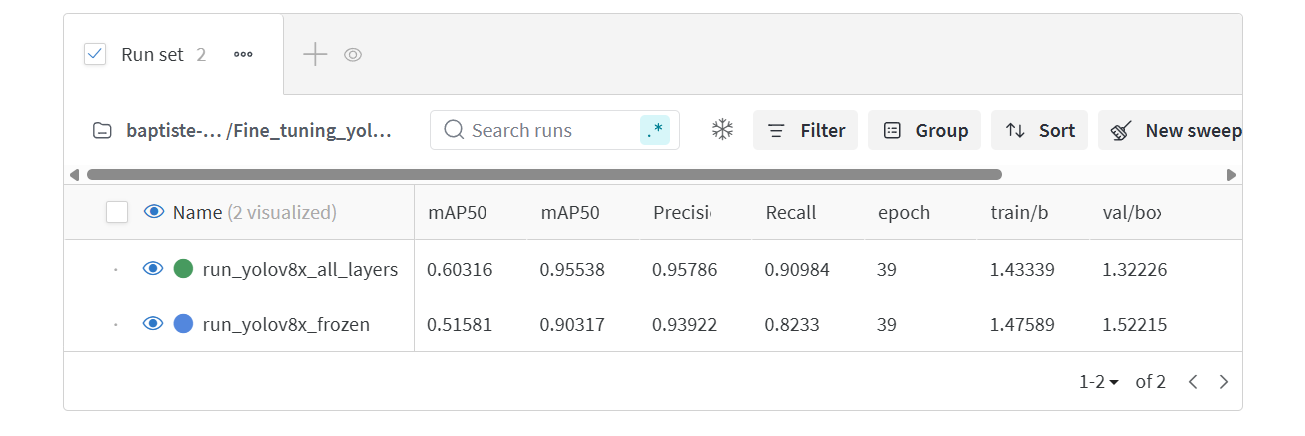

In [ ]:
from IPython.display import Image, display

# Define the path to the folder containing your images
folder_path = '/content/drive/MyDrive/nodule_detection_report'

# Display images
display(Image(filename=os.path.join(folder_path, 'graph yoloxv8.png')))
display(Image(filename=os.path.join(folder_path, 'table yoloxv8.png')))


### 📈 Why YOLOv8x with All Layers Unfrozen Performs Better

The model trained with **all layers unfrozen** (green curves) significantly outperforms the frozen version (blue) across all key metrics:

- **mAP50**: 0.60 vs 0.52  
- **Precision**: 0.96 vs 0.94  
- **Recall**: 0.91 vs 0.82  
- **mAP50-95**: +5% improvement  
- **Lower final box loss** (train & val)

This confirms that unfreezing the backbone helps the model better adapt to the medical imaging domain (e.g., nodules and soft tissue contrast), learning both low- and high-level features more effectively.

📎 [View the full report on WandB →](https://wandb.ai/baptiste-lf-data-self/Fine_tuning_yolov8x/reports/Object-Detection-Model-Comparison-Report--VmlldzoxMzM1NTY4OQ)


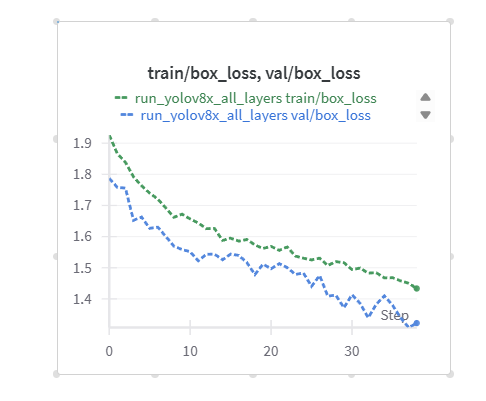

In [ ]:
display(Image(filename=os.path.join(folder_path, 'graph_yoloxv8_fitting.png')))

### 🧪 No Signs of Overfitting or Underfitting

Training and validation box loss curves follow **similar decreasing trends**, with only a small, stable gap (~0.1):

- **train/box_loss**: 1.43  
- **val/box_loss**: 1.32

This indicates:
- The model is **learning progressively**, without memorizing the training set (no overfitting).
- The model is **fitting the data well**, without struggling to capture patterns (no underfitting).

🟢 We'll visually analyze where the model focuses and how it performs, without using interpretability maps.


### Visual Comparison on Validation Set: Ground Truth vs YOLOv8x Predictions


image 1/1 /content/XRay-Chest-Nodule-7/valid/images/img526_jpg.rf.69ef96206b89754e4de7f8b4dc054966.jpg: 640x640 2 nodules, 4396.6ms
Speed: 3.7ms preprocess, 4396.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


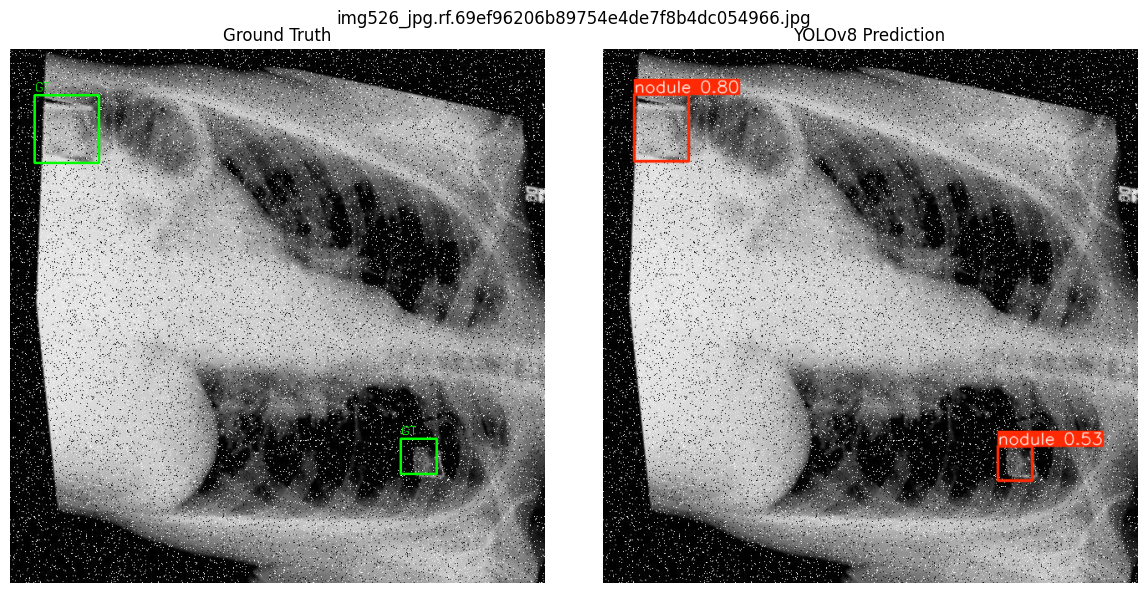


image 1/1 /content/XRay-Chest-Nodule-7/valid/images/img171_jpg.rf.774c9760487edc270a4f7aecd7cecefe.jpg: 640x640 (no detections), 5341.0ms
Speed: 3.8ms preprocess, 5341.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


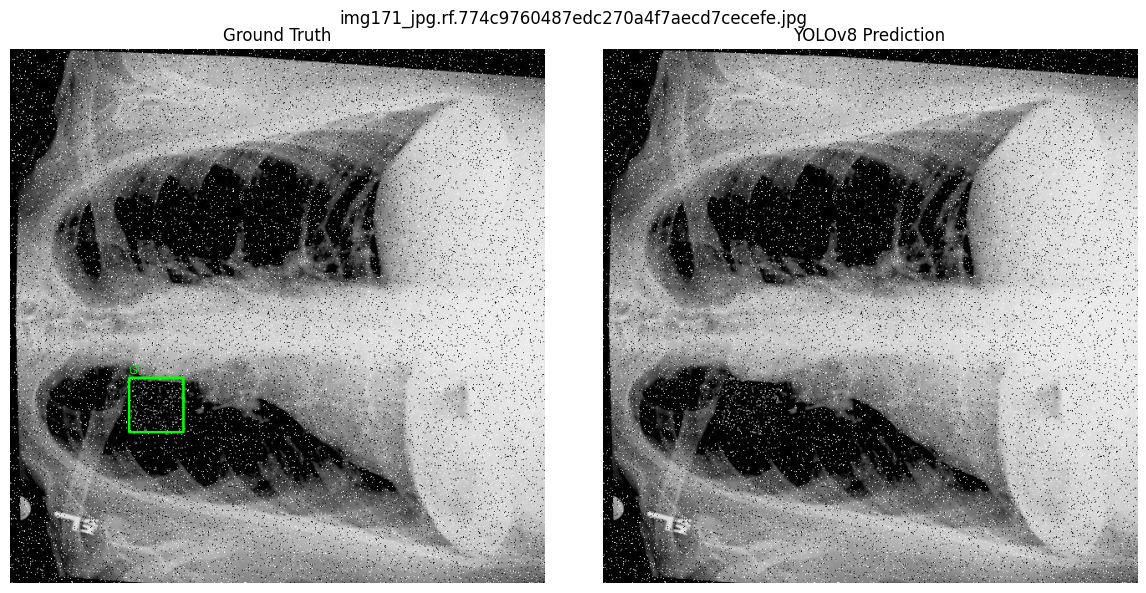


image 1/1 /content/XRay-Chest-Nodule-7/valid/images/img1468_jpg.rf.ccc0e98d682958325327efb62f523a8c.jpg: 640x640 6 nodules, 4077.8ms
Speed: 3.9ms preprocess, 4077.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


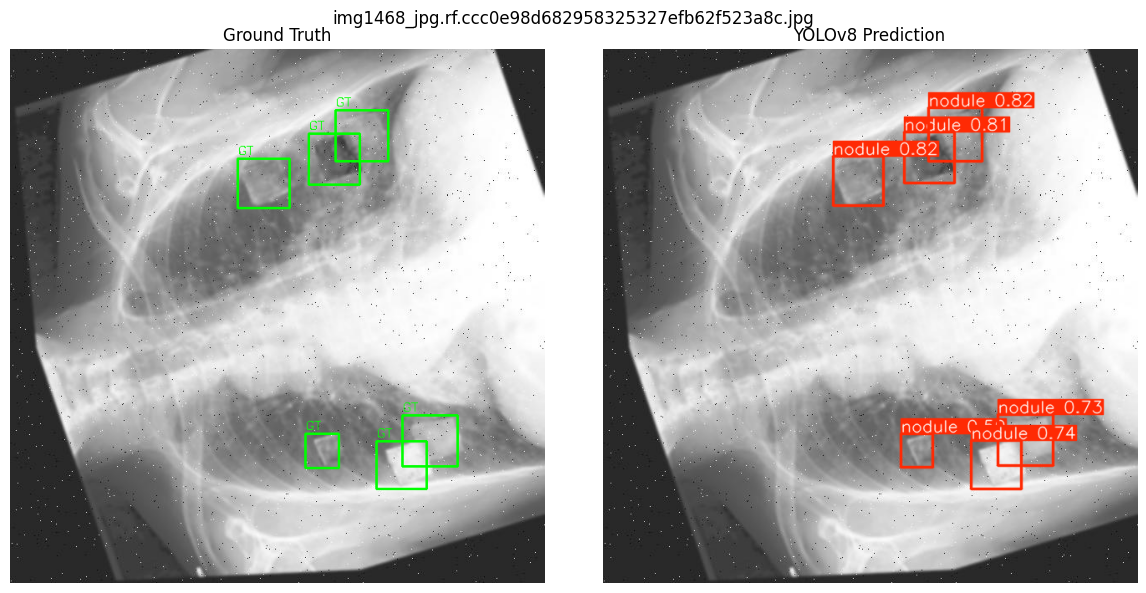


image 1/1 /content/XRay-Chest-Nodule-7/valid/images/img1352_jpg.rf.3a5e2238db7e9985b1c9702a2bc318d2.jpg: 640x640 3 nodules, 4575.9ms
Speed: 3.7ms preprocess, 4575.9ms inference, 9.9ms postprocess per image at shape (1, 3, 640, 640)


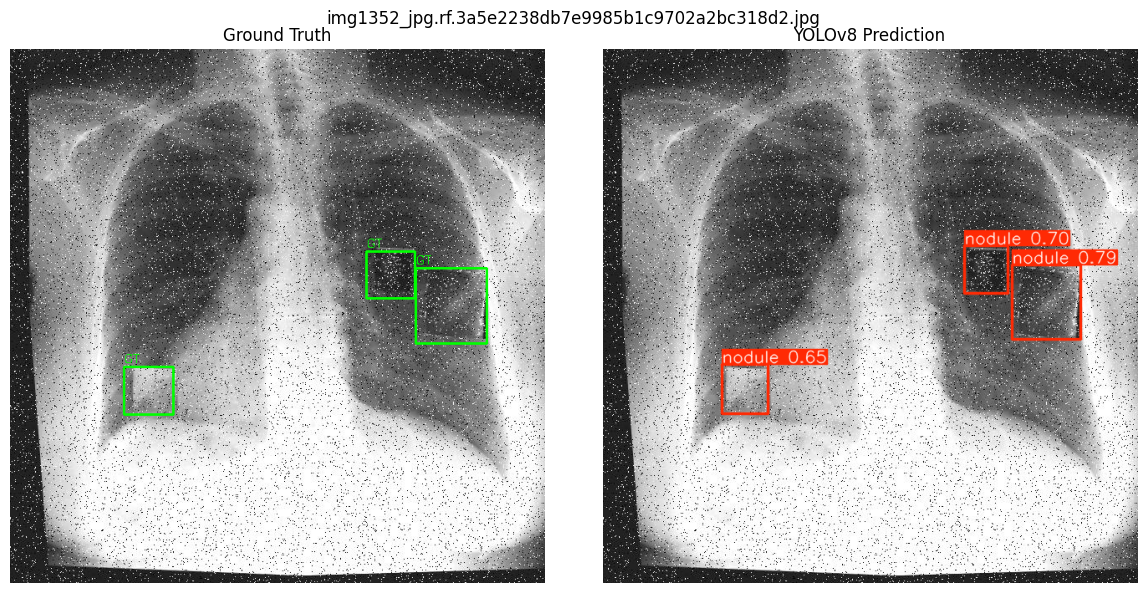

In [15]:
import os
import cv2
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO

# === CONFIG ===
IMAGE_DIR = '/content/XRay-Chest-Nodule-7/valid/images'
LABEL_DIR = '/content/XRay-Chest-Nodule-7/valid/labels'
MODEL_PATH = '/content/drive/MyDrive/yolo_checkpoints/run_yolov8x_all_layers/weights/best.pt'

def plot_images(IMAGE_DIR=IMAGE_DIR, LABEL_DIR=LABEL_DIR, MODEL_PATH=MODEL_PATH):
  # Load model
  model = YOLO(MODEL_PATH)

  # Random sample of 5–10 images
  image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg') or f.endswith('.png')]
  sample_files = random.sample(image_files, 4)

  # Visualization loop
  for filename in sample_files:
      img_path = os.path.join(IMAGE_DIR, filename)
      label_path = os.path.join(LABEL_DIR, filename.replace('.jpg', '.txt').replace('.png', '.txt'))

      # Load image
      img = cv2.imread(img_path)
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img_h, img_w = img.shape[:2]

      # ---- Draw ground truth ----
      gt_img = img_rgb.copy()
      if os.path.exists(label_path):
          with open(label_path, 'r') as f:
              for line in f.readlines():
                  cls, x, y, w, h = map(float, line.strip().split())
                  # Convert YOLO format to pixel coordinates
                  cx, cy, bw, bh = x * img_w, y * img_h, w * img_w, h * img_h
                  x1, y1 = int(cx - bw / 2), int(cy - bh / 2)
                  x2, y2 = int(cx + bw / 2), int(cy + bh / 2)
                  cv2.rectangle(gt_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                  cv2.putText(gt_img, 'GT', (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

      # ---- Run model prediction ----
      results = model(img_path, conf=0.1, iou=0.5)
      pred_img = results[0].plot()

      # ---- Plot side-by-side ----
      plt.figure(figsize=(12, 6))
      plt.subplot(1, 2, 1)
      plt.imshow(gt_img)
      plt.title('Ground Truth')
      plt.axis('off')

      plt.subplot(1, 2, 2)
      plt.imshow(pred_img)
      plt.title('YOLOv8 Prediction')
      plt.axis('off')

      plt.suptitle(filename)
      plt.tight_layout()
      plt.show()

plot_images()


###  Model Generalization on Test Set: Prediction vs Actual Nodules


image 1/1 /content/XRay-Chest-Nodule-7/test/images/img1663_jpg.rf.3cf856742dc08760b28d045a2928613e.jpg: 640x640 (no detections), 4283.4ms
Speed: 3.1ms preprocess, 4283.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


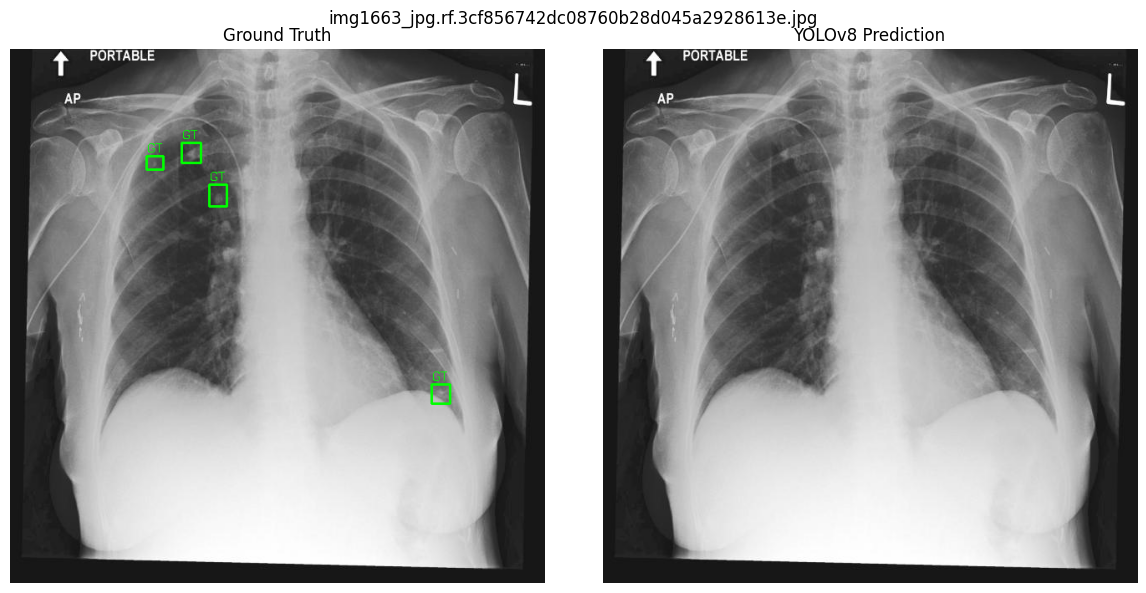


image 1/1 /content/XRay-Chest-Nodule-7/test/images/img1900_jpg.rf.4aea18823b242d02dce86e3e41450db0.jpg: 640x640 2 nodules, 4055.8ms
Speed: 3.3ms preprocess, 4055.8ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


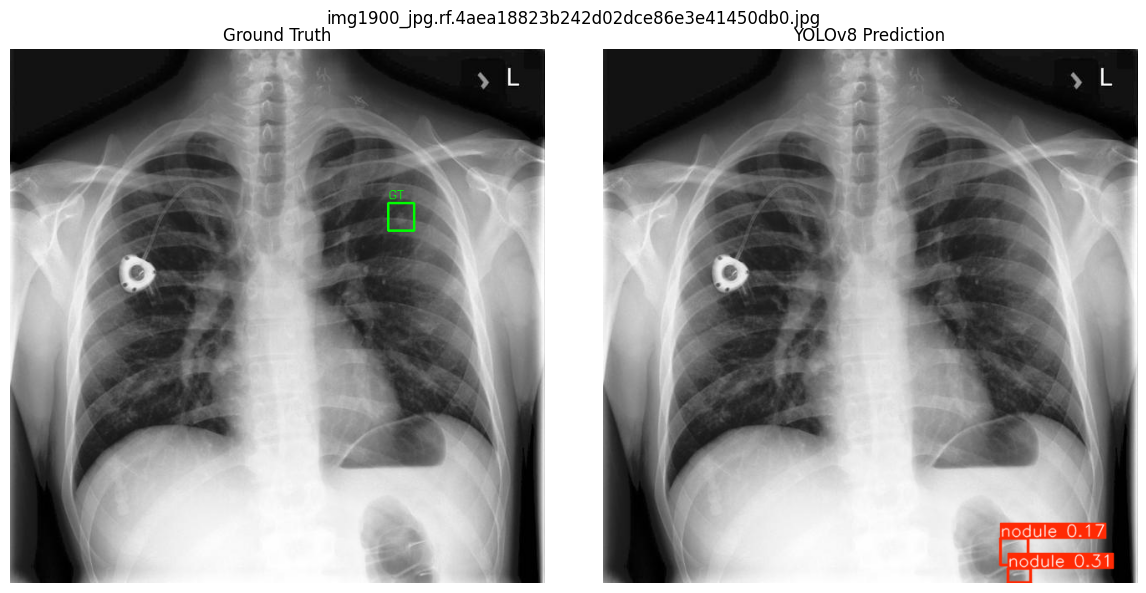


image 1/1 /content/XRay-Chest-Nodule-7/test/images/img1743_jpg.rf.6d572ddaaad627a4c6a2e3b9b9bbb635.jpg: 640x640 (no detections), 5569.0ms
Speed: 6.4ms preprocess, 5569.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


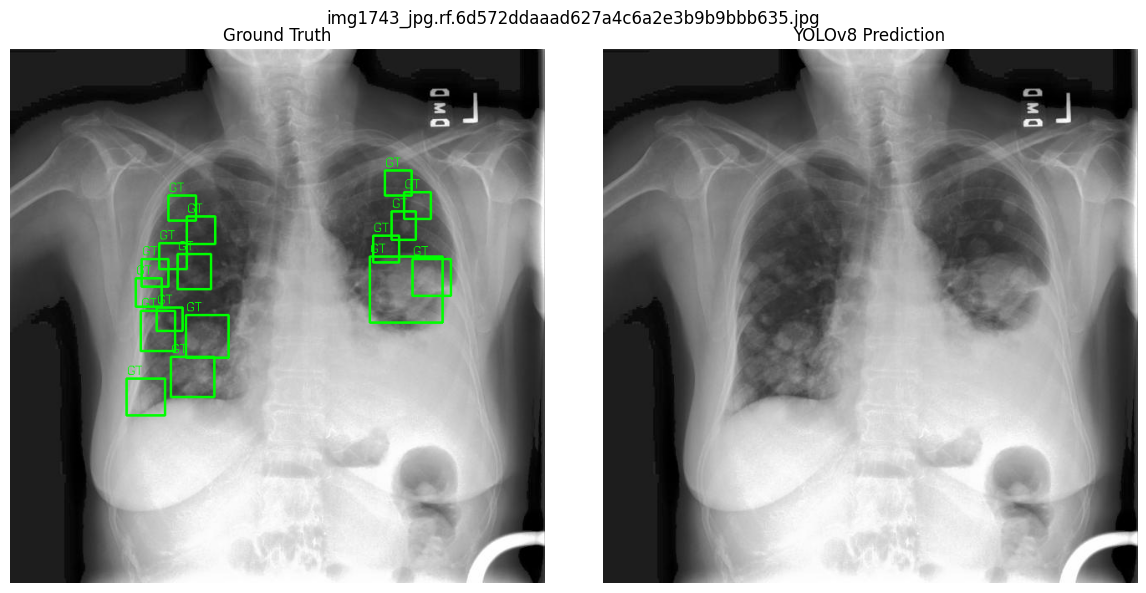


image 1/1 /content/XRay-Chest-Nodule-7/test/images/img1985_jpg.rf.1b61567d1cef70db50b6dafa792d9496.jpg: 640x640 1 nodule, 4104.7ms
Speed: 3.7ms preprocess, 4104.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


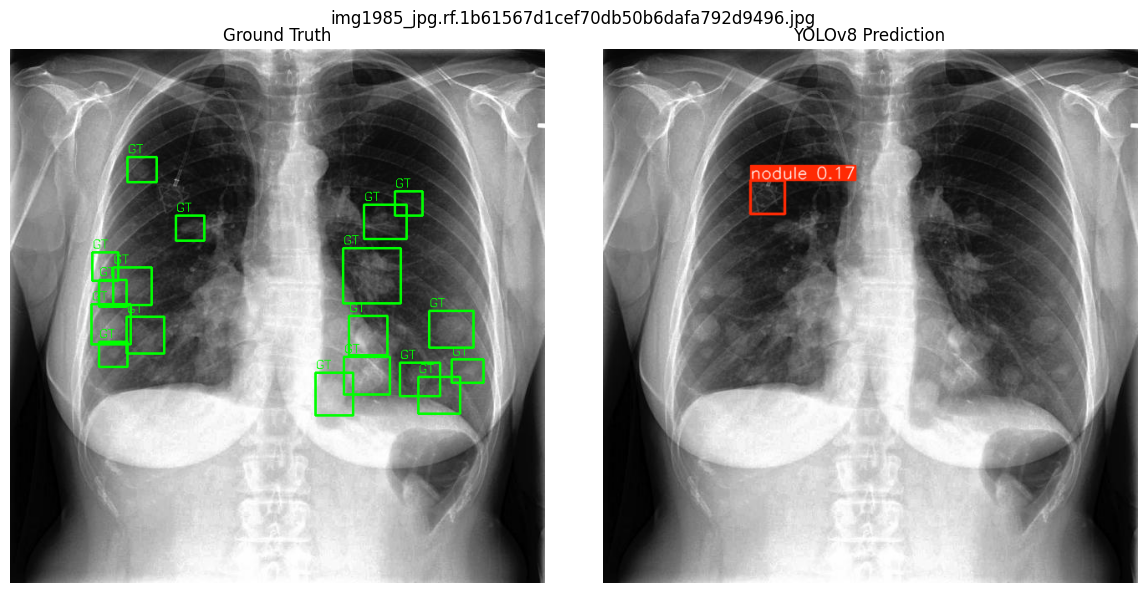

In [17]:
# === CONFIG ===
IMAGE_DIR_TEST = '/content/XRay-Chest-Nodule-7/test/images'
LABEL_DIR_TEST = '/content/XRay-Chest-Nodule-7/test/labels'

plot_images(IMAGE_DIR=IMAGE_DIR_TEST, LABEL_DIR=LABEL_DIR_TEST)

#### The model performs well on validation data, indicating it can learn to detect nodules on known patterns. However, performance on the test set — composed of unseen patients — is significantly lower. This highlights the real-world difficulty of generalizing across individuals in medical imaging. Next steps would include stronger augmentations, more patient diversity, and domain adaptation techniques.

In [8]:
from ultralytics import YOLO

# Load your trained model
model = YOLO("/content/drive/MyDrive/yolo_checkpoints/run_yolov8x_all_layers/weights/best.pt")
# Run evaluation on the test set
metrics = model.val(data="/content/XRay-Chest-Nodule-7/data.yaml",
                    split="test",
                    imgsz=640,
                    conf=0.001,
                    iou=0.5,
                    save=False,)

# Get [mp, mr, map50, map] = mean precision, recall, mAP@50, mAP@50-95
mp, mr, map50, map5095 = metrics.box.mean_results()

# Print rounded results
print("📊 Test set evaluation:")
print("Precision:", round(mp, 2))
print("Recall:", round(mr, 2))
print("mAP@0.5:", round(map50, 2))
print("mAP@0.5:0.95:", round(map5095, 2))


Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1025.3±332.2 MB/s, size: 37.7 KB)


val: Scanning /content/XRay-Chest-Nodule-7/test/labels.cache... 517 images, 0 backgrounds, 0 corrupt: 100%|██████████| 517/517 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:41<00:00,  1.27s/it]


                   all        517       1991     0.0695     0.0779     0.0402     0.0121
Speed: 1.1ms preprocess, 75.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val3
📊 Test set evaluation:
Precision: 0.07
Recall: 0.08
mAP@0.5: 0.04
mAP@0.5:0.95: 0.01


# 📌 Conclusion: Model Performance and Generalization

## Validation Results (YOLOv8x - All Layers)
**mAP@0.5**: 0.60  
**Precision**: 0.96  
**Recall**: 0.91  

These strong validation results show that the model effectively learned to detect nodules from the training data. The low train/val box loss confirms that the model fits the training distribution well.

---

## Test Set Performance (Unseen Patients)
**Precision**: 0.07  
**Recall**: 0.08  
**mAP@0.5**: 0.04  
**mAP@0.5:0.95**: 0.01  

Despite strong validation results, the model fails to generalize to the test set. This is a known issue in medical imaging, where even small differences in image characteristics (e.g., contrast, device, anatomy variation) can significantly affect performance.

✅ **I checked for data leakage** (shared patients or images between train/val/test), and confirmed all splits are patient-disjoint and clean.

---

## ⚠️ Why Did This Happen?

- Test images may come from different acquisition settings or distributions
- YOLO struggles with **tiny, low-contrast lesions** like lung nodules
- The model may have learned dataset-specific patterns instead of generalizable features
- Label noise or subtle nodules in test data may make evaluation very strict

---

## ✅ How to Improve Generalization

- **Data augmentation**: stronger contrast, blur, occlusion, histogram equalization
- **Higher image resolution** (e.g., 1024x1024) for small object detection
- **Domain-adapted backbones**: ResNet/ViT pretrained on X-rays
- **Hard negative mining** to reduce false positives
- **More patient diversity** and larger datasets
- **Tune confidence/IoU thresholds** for small objects

---

## 🧠 Final Takeaway

This project demonstrates the common and realistic challenge of generalization in medical AI. Instead of hiding it, this result gives insight into the **limitations of detection models** in medical imaging and outlines how to move forward responsibly.

> The project not only achieved strong in-distribution performance but also highlighted where and why generalization fails — a crucial lesson for real-world deployment.
